In [ ]:
pip install requests beautifulsoup4 robustbase


  Preparing metadata (setup.py) ... done
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7435 sha256=3baf30cc000ef21b20a6347e62d17217e8491bfbf157ba9565ac2e7ea228b31d
  Stored in directory: /root/.cache/pip/wheels/a7/30/34/fceae1c718a4e749dd51f479c5720c0671519887e824915e90
Successfully built statistics


In [1]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [3]:
import json
import pandas as pd
import re

df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


df = df.dropna(subset=["Price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""




def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["Product Name"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["Product Name", "Price"])

    # Drop duplicates based on 'name' and 'Price'
    df = df.drop_duplicates(subset=["Product Name", "Price"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)



<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_17920\3410007019.py:5: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


In [4]:
df_highlighter = df[df["Product type"].str.strip().str.lower() == "highlighter"]
print(df_highlighter[["Product Name", "volume", "Price"]])
print(df_highlighter.shape)


                                           Product Name    volume    Price
1465                          5coclors All of the light       NaN       79
2120       AMYTIS GARDEN 5 Color Highlighter Palette 01       NaN       36
2103       AMYTIS GARDEN 5 Color Highlighter Palette 02       NaN       36
2131  ANASTASIA BEVERLY HILLS Aurora Glow highlighte...       NaN     84.5
3751    ANASTASIA BEVERLY HILLS Glow Seeker Highlighter       NaN   170.00
...                                                 ...       ...      ...
1486  wet n wild MegaGlo Highlighting Powder, Highli...       NaN       47
1547  wet n wild MegaGlo Loose Highlighting Powder M...       NaN    92.84
1559  wet n wild Megaglo Contouring Palette, Dulce D...  13.01234      179
1501  wet n wild Saved By The Bell Highlighter + Ill...       NaN    75.08
1528  wet n wild Saved By The Bell Highlighter + Ill...       NaN       59

[306 rows x 3 columns]
(306, 8)


In [5]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df_highlighter["Product Name"].apply(is_multi_item)

# Split the DataFrame
sets_df_highlighter = df_highlighter[mask_sets].copy()
df_highlighter = df_highlighter[~mask_sets].copy()

# Optional: Reset index if needed
sets_df_highlighter.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df_highlighter["Price"] = df_highlighter["Price"].replace(r"[^\d.]", "", regex=True).astype(float)


In [7]:
print(df_highlighter["Price"].describe())


count    300.000000
mean     108.113700
std       93.852908
min       13.000000
25%       39.617500
50%       78.395000
75%      140.000000
max      563.000000
Name: Price, dtype: float64


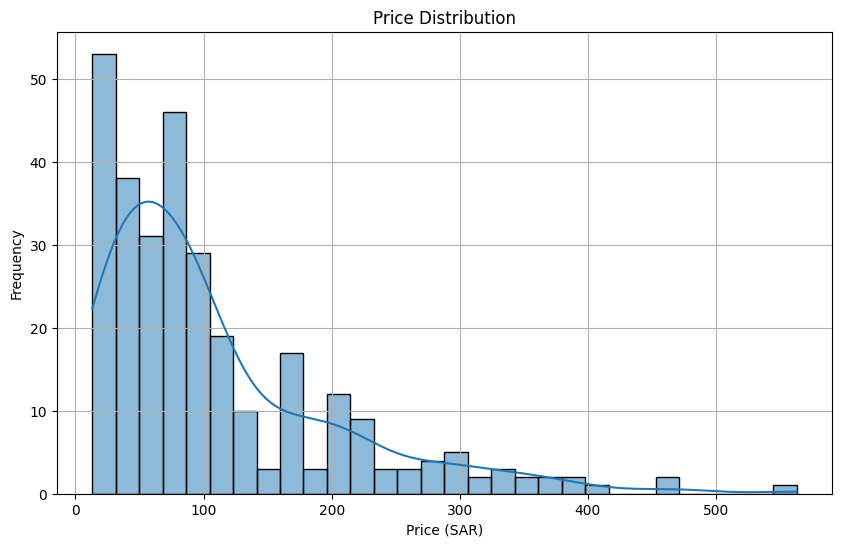

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_highlighter["Price"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [9]:
df_highlighter = df_highlighter.dropna(subset=["Product Name", "Price"])
df_highlighter.shape

(300, 8)

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation to the cleaned numeric price column
df_highlighter["price_log"] = np.log1p(df_highlighter["Price"])

# Then apply standard scaling
scaler = StandardScaler()
df_highlighter["price_scaled"] = scaler.fit_transform(df_highlighter[["price_log"]])


C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 

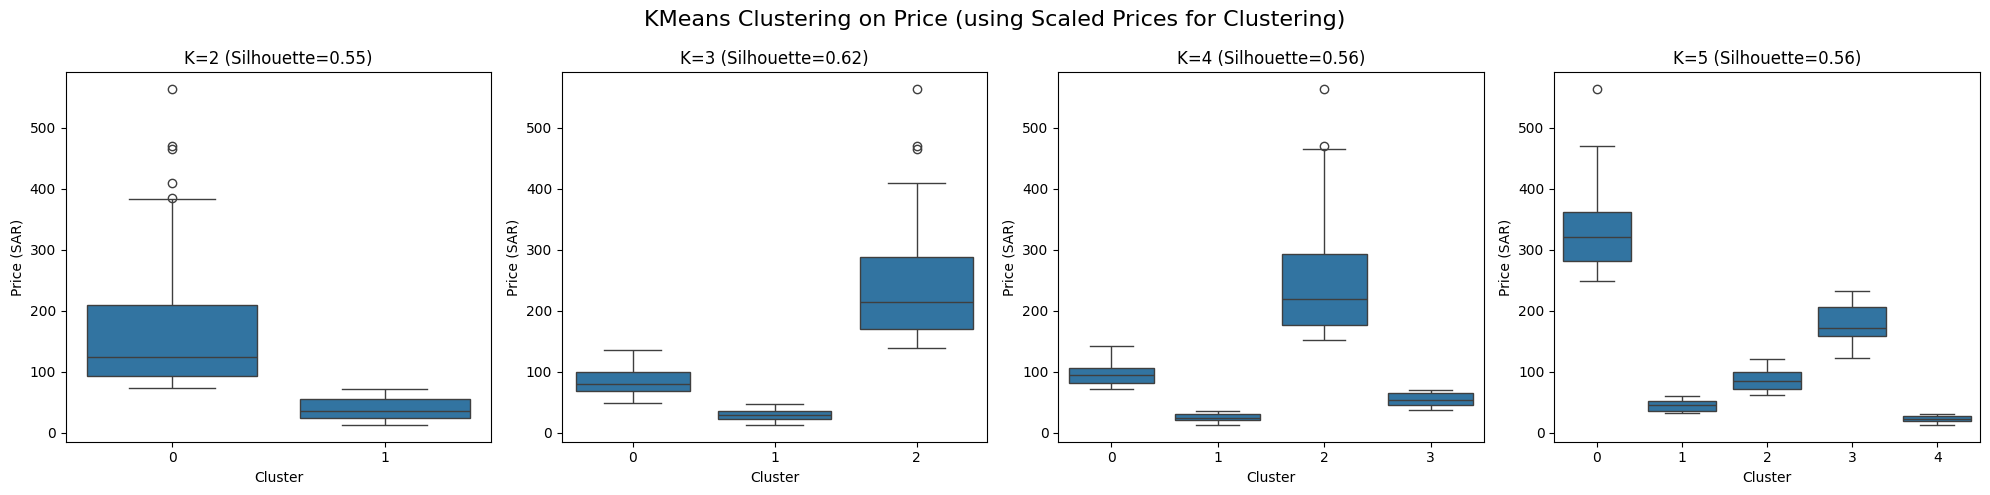

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_highlighter[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_highlighter) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_highlighter[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="Price",  # Show real prices
        data=df_highlighter,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


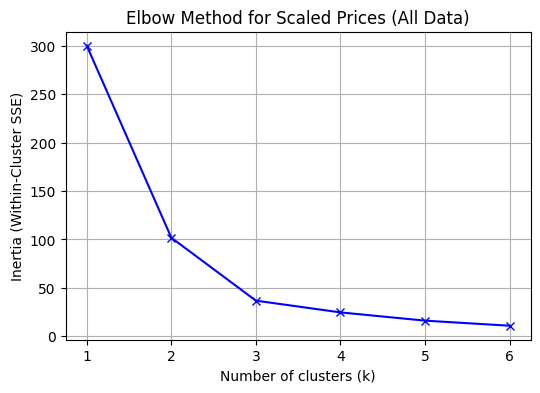

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_highlighter[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_highlighter[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Assign cluster labels back to df_cleaned
df_highlighter= df_highlighter.copy()  # optional: avoid modifying original
df_highlighter["final_cluster"] = kmeans.labels_

# 4. Show actual price statistics per cluster
summary = (
    df_highlighter
    .groupby("final_cluster")["Price"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count        mean     min    max
final_cluster                                  
0                132   83.533712   49.35  135.0
1                 90   29.692667   13.00   47.9
2                 78  240.196410  139.00  563.0


In [14]:
low = df_highlighter[
    (df_highlighter["final_cluster"] == 1)
]
low

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
2120,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/5-color-highligh...,NaN,AMYTIS GARDEN 5 Color Highlighter Palette 01,36.00,NaN,3.610918,-0.920299,1,1,1,1,1
2103,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/5-color-highligh...,NaN,AMYTIS GARDEN 5 Color Highlighter Palette 02,36.00,NaN,3.610918,-0.920299,1,1,1,1,1
2127,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/face-highlighter...,NaN,BOLVER Face Highlighter 2 Colors,26.95,NaN,3.330417,-1.262832,1,1,1,4,1
2132,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/highlighter-make...,NaN,BOLVER Highlighter Makeup Palette 03,33.65,NaN,3.545298,-1.000431,1,1,1,1,1
2149,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/highlighter-make...,https://f.nooncdn.com/p/pzsku/ZD9695FD8C390224...,BOLVER Highlighter Makeup Palette 03,34.35,NaN,3.565298,-0.976007,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/cindy-lou-manize...,NaN,theBalm Cindy-Lou Manizer Highlighter Beige,24.00,NaN,3.218876,-1.399041,1,1,1,4,1
2138,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/escaped-cindy-lo...,https://f.nooncdn.com/p/v1615999708/N21507596A...,theBalm Escaped Cindy-Lou Manizer Highlighter ...,27.00,NaN,3.332205,-1.260649,1,1,1,4,1
2136,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/let-s-bolt-highl...,NaN,theBalm Let's Bolt Highlighter and Enlumineur ...,41.00,NaN,3.737670,-0.765516,1,1,3,1,1
2116,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/mary-lou-luminiz...,NaN,theBalm Mary Lou Luminizer Manizer Highlighter...,33.00,NaN,3.526361,-1.023556,1,1,1,1,1


In [15]:
mid = df_highlighter[
    (df_highlighter["final_cluster"] == 0)
]
mid

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
1465,NaN,Amazon,Highlighter,https://www.amazon.sa/-/en/5coclors-All-of-the...,https://m.media-amazon.com/images/I/61o7UjKwUx...,5coclors All of the light,79.00,NaN,4.382027,0.021340,0,0,0,2,0
2131,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/aurora-glow-high...,NaN,ANASTASIA BEVERLY HILLS Aurora Glow highlighte...,84.50,NaN,4.448516,0.102534,0,0,0,2,0
2124,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/ultimate-glow-ki...,NaN,ANASTASIA BEVERLY HILLS Ultimate Glow Kit High...,66.95,NaN,4.218772,-0.178018,1,0,3,2,0
2159,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/ultra-colour-pal...,https://f.nooncdn.com/p/pnsku/N70151686V/45/_/...,AVON Ultra Colour Palette 3 in 1 Golden Hour,85.00,NaN,4.454347,0.109655,0,0,0,2,0
3754,NaN,Sephora,Highlighter,https://www.sephora.me/sa-en/p/high-beam-liqui...,https://img-product.sephora.me/dw/image/v2/BKW...,BENEFIT COSMETICS High Beam Liquid Face Highli...,105.00,NaN,4.663439,0.364987,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,NaN,Amazon,Highlighter,https://www.amazon.sa/-/en/Highlighter-Multi-D...,https://m.media-amazon.com/images/I/91u1kjQFHZ...,"wet n wild Hello Kitty Highlighter Trio, Multi...",76.43,NaN,4.349374,-0.018533,0,0,0,2,0
1548,NaN,Amazon,Highlighter,https://www.amazon.sa/-/en/MegaGlo-Highlightin...,https://m.media-amazon.com/images/I/81ofvh5k62...,wet n wild MegaGlo Highlighting Bar Zodiac Col...,77.68,NaN,4.365389,0.001023,0,0,0,2,0
1547,NaN,Amazon,Highlighter,https://www.amazon.sa/-/en/MegaGlo-Highlightin...,https://m.media-amazon.com/images/I/819wYMkSKX...,wet n wild MegaGlo Loose Highlighting Powder M...,92.84,NaN,4.541591,0.216193,0,0,0,2,0
1501,NaN,Amazon,Highlighter,https://www.amazon.sa/-/en/Highlighter-Illumin...,https://m.media-amazon.com/images/I/91Q67LDT6h...,wet n wild Saved By The Bell Highlighter + Ill...,75.08,NaN,4.331785,-0.040012,0,0,0,2,0


In [16]:
high = df_highlighter[
    (df_highlighter["final_cluster"] == 2)
]
high

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
3751,NaN,Sephora,Highlighter,https://www.sephora.me/sa-en/p/glow-seeker-hig...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Glow Seeker Highlighter,170.0,NaN,5.141664,0.948971,0,2,2,3,2
3769,NaN,Sephora,Highlighter,https://www.sephora.me/sa-en/p/iced-out-powder...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Iced Out - Powder High...,175.0,NaN,5.170484,0.984165,0,2,2,3,2
3775,NaN,Sephora,Highlighter,https://www.sephora.me/sa-en/p/fluid-sheer-glo...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Fluid Sheer Glow Enhancer,213.0,NaN,5.365976,1.222890,0,2,2,3,2
3753,NaN,Sephora,Highlighter,https://www.sephora.me/sa-en/p/luminous-silk-a...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Luminous Silk Acqua - Highlighter,233.0,NaN,5.455321,1.331994,0,2,2,3,2
3776,NaN,Sephora,Highlighter,https://www.sephora.me/sa-en/p/luminous-silk-g...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Luminous Silk Golden Glow Highlighter,275.0,NaN,5.620401,1.533581,0,2,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,NaN,Sephora,Highlighter,https://www.sephora.me/sa-en/p/touche-%C3%A9cl...,https://img-product.sephora.me/dw/image/v2/BKW...,YVES SAINT LAURENT Touche Éclat Blur Primer - ...,294.0,NaN,5.686975,1.614878,0,2,2,0,2
1546,NaN,Amazon,Highlighter,https://www.amazon.sa/-/en/l-f-Cosmetics-Bronz...,https://m.media-amazon.com/images/I/615KcYC6O8...,"e.l.f. Cosmetics, Bronzer (Golden, 4 Shades, 0...",288.0,15.673955,5.666427,1.589785,0,2,2,0,2
1545,NaN,Amazon,Highlighter,https://www.amazon.sa/-/en/l-f-Studio-Highligh...,https://m.media-amazon.com/images/I/81UePhEjZO...,e.l.f. Studio Baked Highlighter in Moonlight P...,323.0,NaN,5.780744,1.729383,0,2,2,0,2
2143,NaN,Noon,Highlighter,https://www.noon.com/saudi-en/face-illuminator...,https://f.nooncdn.com/p/v1595066281/N39373126A...,laura mercier Face Illuminator Highlighting Po...,210.0,NaN,5.351858,1.205650,0,2,2,3,2
